In [2]:

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

import math
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes
from spectral_cube import LazyMask
from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
from astrodendro.analysis import PPVStatistic


print(astrodendro.__file__)

from matplotlib.patches import Ellipse
import copy
from tqdm import tqdm
import radio_beam

from scipy.optimize import curve_fit
from scipy.optimize import leastsq
#%matplotlib widget
from astropy.convolution import Gaussian1DKernel

/home/ben/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16
/home/ben/.local/lib/python3.8/site-packages/astrodendro/__init__.py


# Part 8: Dendograms

In [3]:

#Create a function that uses the dendrogram input to calculate all the quantities, and has the size and linewidth requirements of the Shetty paper
#Requires the computed dendrogram, the data from the line image, the velocity axis, and the data from the Continuum image, as well as metadata for the structures
#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
#Continuum is in Jansky/Beam, Line data should have the unit specified in the metadata as 'data_unit'

def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata,ColD = True):
    SizeA,SigmaA,LuminA,CDA,SIDS,MOM0_FLUX = [[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]
    print(metadata)
    for t in Dendrogram.all_structures: 

        I = t.indices()
        Cont = True
        if t.is_branch:
                if t.parent==None:
                    Cont=True
                else:
                    Cont = True#False

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            

            nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
            v_IWM = np.nansum(LineData[I]*(DataVel[I[0]])/u.km*u.s)/np.nansum(LineData[I])
            sig_Sh = np.sqrt(np.nansum(LineData[I]*((DataVel[I[0]])/u.km*u.s-v_IWM)**2)/np.nansum(LineData[I])) 

                #The flux from the continuum
                #Convert to Jansky from Jansky per beam:
            if((float(np.sqrt(nproj_pix*(area_res)/np.pi)))*10**6<40 and (float(np.sqrt(nproj_pix*(area_res)/np.pi)))*10**6>2 and (float(sig_Sh))>2):
                    
                if(ColD ==True):
                    Cont_Flux=0

                    proj = tuple(set(zip(*tuple(I[i] for i in [1,2]))))
                    for lmi in range(len(proj)):

                        Cont_Flux+=ContData[proj[lmi]]
                    Cont_Flux=Cont_Flux/(metadata['beam_area_ratioc']*(2*np.sqrt(2*np.log(2))))*u.pix**2*u.beam/u.beam*u.Jy#SHould be input as Jansky /beam and will be converted to Jansky, then to unitless. The beam is changed from FWHM to Gaussian
                    Dust_Column = Flux_to_Mass(Cont_Flux)*Num_per_kg/((s.radius*np.pi/180*8.178*10**-3/u.deg)**2*(3.086*10**24)**2)/np.pi*(1.989*10**30*u.kg/u.M_sun)/u.kg
                else:
                    Dust_Column=0
                if(str(Dust_Column) == str(np.nan) or str(Dust_Column)==str(np.inf)):
                    Dust_Column=0
                lum = Flux_to_Lum(s.flux)
                s_flux = s.flux

                Index = tuple(I[i] for i in [0,1,2])
                K_Km_s_Flux=np.nansum(LineData[Index]*metadata["velocity_scale"])#Find the total flux from the structures in K km/s, assuming the input data is in K as it should be, 

                if(t.is_leaf):
                    #Make extra rows for shetty parametization and filtering
                    SizeA[0].append((float(np.sqrt(nproj_pix*(area_res)/np.pi)))) #define size as shetty does
                    SigmaA[0].append((float(sig_Sh)))#basically same as dendro
                    
                    CDA[0].append(float(Dust_Column))
                    LuminA[0].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[0].append(float(t.idx))
                    MOM0_FLUX[0].append(float(K_Km_s_Flux*u.s/u.km))
                if(t.is_branch	):
                    #Make extra rows for shetty parametization and filtering
                    SizeA[1].append((float(np.sqrt(nproj_pix*(area_res)/np.pi)))) #define size as shetty does
                    SigmaA[1].append((float(sig_Sh)))#basically same as dendro
                    
                    CDA[1].append(float(Dust_Column))
                    LuminA[1].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[1].append(float(t.idx))
                    MOM0_FLUX[1].append(float(K_Km_s_Flux*u.s/u.km))
    SizeA[0] = np.array(SizeA[0],dtype=type(1.))
    SizeA[1] = np.array(SizeA[1],dtype=type(1.))
    
    SigmaA[0] = np.array(SigmaA[0],dtype=type(1.))
    SigmaA[1] = np.array(SigmaA[1],dtype=type(1.))
    
    CDA[0] = np.array(CDA[0],dtype=type(1.))
    CDA[1] = np.array(CDA[1],dtype=type(1.))
    LuminA[0] = np.array(LuminA[0],dtype=type(1.))
    LuminA[1] = np.array(LuminA[1],dtype=type(1.))
    SIDS[0] = np.array(SIDS[0],dtype=type(1.))
    SIDS[1] = np.array(SIDS[1],dtype=type(1.))
    MOM0_FLUX[0] = np.array(MOM0_FLUX[0],dtype=type(1.))
    MOM0_FLUX[1] = np.array(MOM0_FLUX[1],dtype=type(1.))
    
    return np.array(SizeA),np.array(SigmaA),np.array(CDA),np.array(LuminA),np.array(SIDS),np.array(MOM0_FLUX)

#Make a function to make an image 

#Data to plot, minimum of color bar, maximum, WCS projection for coords, and position of the image in the larger figure
def Make_Plot(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=0.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
def Make_Plot_Anno(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show,pos1,pos2):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
        
        
#Put this up here for the column density map
def Flux_to_Mass(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(8.178*10**-3*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    
    a_850 = 6.7*10**19*u.erg/u.s/u.Hz/u.M_sun #6.7+-1.7
    
    M_mol = L/a_850#Just in Solar mass*1.989*10**30*u.kg/u.M_sun #Determines mass of the cont for 850 in kg
    return M_mol
def Flux_to_Lum(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(8.178*10**-3*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    return L


def Find_Pixel_D(flux,metadata,sub = "Nope"):
    center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
    
    x,y = [metadata["Cwcs"].world_to_pixel(center)[0],(metadata["Cwcs"].world_to_pixel(center)[1])]
    d0 = 8.178 *10**-3*u.Mpc #mpc
    D_Es = np.empty(np.shape(flux))
    for lmi in range(len(flux)):
        for lmj in range(len(flux[lmi])):
            #Find the distance to earth from every pixel
            D_Es[lmi][lmj] = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((lmj-x)**2+(lmi-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )/u.Mpc#Has to be unitless so it saves, so bring the unit back when it is loaded
            
    #print(D_Es)
    if(sub=="Nope"):
        np.save("Pixel_D",D_Es)
    else:
        np.save(sub,D_Es)

#path ="Noise_Matched_CMZ_CO_3_2_355_005.fits"
#cmz_cube=SpectralCube.read(path)
#Find_Pixel_D(cmz_cube.moment0().hdu.data,metadata)

#Return a cropped cube for some ra and dec, also crops the velocity axis if needed (0 for no crop)
def Crop(cube,WCS,Np1,Np2,BadVel,D2):
    NraDP1 = [int(WCS.world_to_pixel(Np1)[0]),int(WCS.world_to_pixel(Np1)[1])]
    NraDP2 = [int(WCS.world_to_pixel(Np2)[0]),int(WCS.world_to_pixel(Np2)[1])]
    if(D2==False):
        return cube[BadVel:np.shape(cube)[0]-BadVel,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    if(D2==True):
        return cube[NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,1,True)
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,2,True)

['CMZ_HCO+_Sh_J1_0', '1', '2', '3', '4', '5', '6', '7']
CMZ_HCO+_Sh_J1_0
OG noise =  0.08540336624851072 K
0.04969287595299121 <class 'numpy.float64'> <class 'float'> <class 'astropy.units.quantity.Quantity'> False
(2, 90306) (2, 30375)


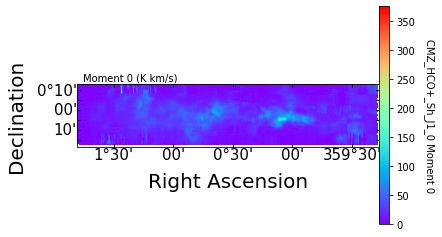

[[ 0.04969288 -0.09151475 -0.03482015 ... -0.04649186 -0.02498817
   0.04086212]
 [ 0.00907717 -0.0096705  -0.04935425 ... -0.03057329 -0.03776616
  -0.02158245]
 [ 0.01559701  0.02700001 -0.03176553 ... -0.03000994 -0.0960382
  -0.07080086]
 ...
 [-0.05006835 -0.0017813   0.00145396 ... -0.0842462  -0.04370653
  -0.04293364]
 [ 0.01491135 -0.0935826  -0.0446304  ... -0.04268911 -0.03870276
  -0.04610665]
 [-0.01949708 -0.06646024 -0.08801047 ... -0.02832625  0.0260223
   0.0248368 ]] Jy / beam 2.6128383149453174 beam pix4 1.468247153076364e+18 cm 1.9890000000000002e+30 kg / solMass
(2, 90306) (2, 30375) a
bp (2, 33987) (2, 8834)
4.5084996752111514e+21 1 / cm2 <class 'astropy.units.quantity.Quantity'> <class 'float'> <class 'astropy.units.quantity.Quantity'> True
(2, 90306) (2, 30375)


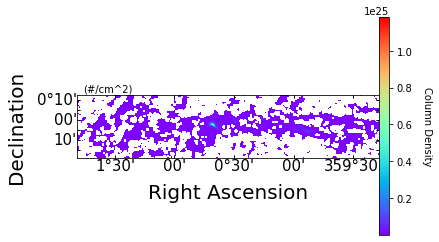

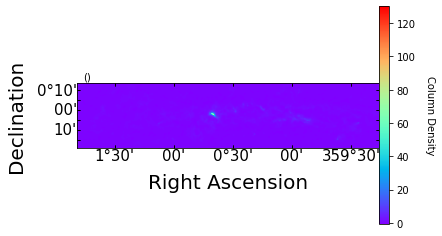

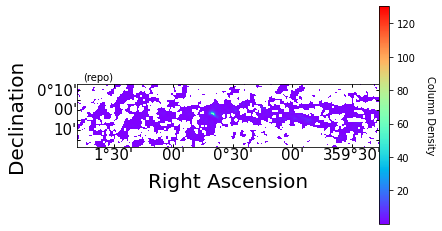

1.181099845600402e+25 1 / cm2 t
4.5084996752111514e+21 1 / cm2 <class 'astropy.units.quantity.Quantity'> <class 'float'> <class 'astropy.units.quantity.Quantity'> True
(2, 86694) (2, 0)


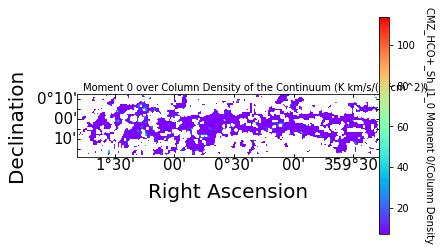

0.02331157451263555

1 89188526000.0 Hz 0.003361334371643276 m
2.263635474695002e-13 <class 'float'>
38.98800015444 arcsec 38.98800015444 arcsec
11.960897802424158 pix2
Done


In [7]:


#HCO 
#
#
#
#
Num=0
Ram_Limiter=1#What percent of the cube my ram can handle
NGCCO32_Noise = 0.115*u.K
LineN="CMZ_HCO+_Sh_J1_0"
Name = "CMZ_HCO+_Sh_J1_0"
name = "CMZ_HCO+_Sh_J1_0_CM_Contours.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2

try:
    Names= list(np.load("Names_CMZ_Sh.npy"))
except:
    Names=[0,1,2,3,4,5,6,7]

Names[Num] = str(Name)
print(Names)
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_CMZ_Sh",Names)

print(Name)




path ="CMZ_Whole_HCO+_Sh_J1_0.fits"

pathCont = 'CMZ_Continuum_Splice.fits'


#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
shape=np.shape(Qp)
Qp = Qp[3:shape[0]-3,3:shape[1]-3,3:shape[2]-3]#Get rid of the excess nan parts
Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()

m = (np.nanstd(sc.hdu.data[0,:,:])) #Noise K
print("OG noise = ",m,"K")
#m=NGCCO32_Noise.value
#print("NGC_Matched noise = ",m,"K")
scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn#[:,50:1300,50:1500]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat#[:,50:1300,50:1500]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


#Put this up here for the column density map
metadata = {}
metadata["distance"] = 8.178*10**-3*u.Mpc
arc_per_pix_yc =  abs(scContW.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scContW.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scContW.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scContW.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scContW.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc







#ggg = np.where(np.array(cSD*u.cm**2,dtype=type(1.0))!=np.nan)
#bgg = np.where(np.array(cSD*u.cm**2,dtype=type(1.0))==np.nan)
aaa = np.where(scContW.hdu.data>0)
bbb = np.where(scContW.hdu.data<0)
print(scContW.hdu.data[0][0],type(scContW.hdu.data[0][0]),type(np.nan),type(u.Quantity(np.nan)),type(u.Quantity(np.nan))==type(scContW.hdu.data[0][0]))
print(np.shape(aaa),np.shape(bbb))

Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
print(scContW.hdu.data*u.Jy/u.beam,beam_area_ratioc*u.pix**2*u.beam,pc_per_pixelc*10**6*3.086*10**18*u.cm,1.989*10**30*u.kg/u.M_sun)
aaa = np.where(scContW.hdu.data>0)
bbb = np.where(scContW.hdu.data<0)

print(np.shape(aaa),np.shape(bbb),"a")

rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=.1*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
print("bp",np.shape(bp),np.shape(bp2))
Continuum_Data[bp] = np.nan
#ggg = np.where(np.array(cSD*u.cm**2,dtype=type(1.0))!=np.nan)
#bgg = np.where(np.array(cSD*u.cm**2,dtype=type(1.0))==np.nan)
aaa = np.where(cSD>0)
bbb = np.where(cSD<0)
print(cSD[0][0],type(cSD[0][0]),type(np.nan),type(u.Quantity(np.nan)),type(u.Quantity(np.nan))==type(cSD[0][0]))
print(np.shape(aaa),np.shape(bbb))

cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan

Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","()",scCont.hdu.data,float(np.nanmin(scCont.hdu.data)),float(np.nanmax(scCont.hdu.data)),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(repo)",scContW.hdu.data,float(np.nanmin(scContW.hdu.data)),float(np.nanmax(scContW.hdu.data)),scContW.wcs,1,1,1,True)
print(np.nanmax(cSD),'t')
#ggg = np.where(np.array(cSD*u.cm**2,dtype=type(1.0))!=np.nan)
#bgg = np.where(np.array(cSD*u.cm**2,dtype=type(1.0))==np.nan)
aaa = np.where(cSD>0)
bbb = np.where(cSD<0)
print(cSD[0][0],type(cSD[0][0]),type(np.nan),type(u.Quantity(np.nan)),type(u.Quantity(np.nan))==type(cSD[0][0]))
print(np.shape(aaa),np.shape(bbb))
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*(8.178*10**-3))**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0

d = astrodendro.Dendrogram.compute(datn,min_delta=m*2,min_value=m*5,min_npix=50) #The main culprit

d.save_to((Name+"_Dendrogram"),"fits")
print("Done")